### GRU PIPELINE

In [2]:
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/')

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from backend.ml_pipe.data.dataModule.gru.dataModule import DataModule
from backend.ml_pipe.models.gru.model import GRUModel, AttentionLayer
from backend.ml_pipe.data.database.mongodb import MongoDb
from pytorch_lightning.callbacks import EarlyStopping
import torch

import random
from pytorch_lightning.loggers import CSVLogger
from backend.ml_pipe.data.dataModule.gru.dataModule import DataModule
from backend.ml_pipe.data.database.mongodb import MongoDb
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import torch.nn as nn

In [2]:
def get_latest_metrics_df(log_root="/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training"):
    # Alle Versionen in log_root auflisten
    versions = [d for d in os.listdir(log_root) if d.startswith("version_")]
    if not versions:
        raise FileNotFoundError(f"Keine Versionen gefunden in {log_root}")
    
    # Höchste Version wählen
    latest_version = sorted(versions, key=lambda x: int(x.split("_")[1]))[-1]
    latest_path = os.path.join(log_root, latest_version, "metrics.csv")
    
    if not os.path.exists(latest_path):
        raise FileNotFoundError(f"metrics.csv nicht gefunden in {latest_path}")
    
    print(f"Verwende Metriken aus: {latest_path}")
    return pd.read_csv(latest_path)

In [3]:
def print_training_summary(csv_logger):
    metrics = get_latest_metrics_df()

    # Nur Zeilen mit gültigem Validation Loss
    valid_rows = metrics[~metrics['val_loss'].isna() & ~metrics['train_loss'].isna()]
    if valid_rows.empty:
        print("Keine gültigen Metriken gefunden.")
        return

    print("\n=== Training Zusammenfassung ===")
    print(f"Anzahl Epochen: {valid_rows['epoch'].nunique()}")
    print(f"Letzter gültiger Train Loss: {valid_rows['train_loss'].iloc[-1]:.4f}")
    print(f"Letzter gültiger Val Loss:   {valid_rows['val_loss'].iloc[-1]:.4f}")
    overfit_ratio = valid_rows['val_loss'].iloc[-1] / valid_rows['train_loss'].iloc[-1]
    print(f"Overfitting Ratio:           {overfit_ratio:.2f}")

In [4]:
def plot_training_metrics(csv_logger):
    metrics = get_latest_metrics_df()

    metrics = metrics.dropna(subset=['step'])

    fig, axs = plt.subplots(2, 1, figsize=(12, 14))

    def safe_plot(ax, x, y, label):
        if y in metrics.columns and metrics[y].notna().sum() > 0:
            sns.lineplot(data=metrics, x=x, y=y, label=label, ax=ax)

    # Plot 1: Loss
    safe_plot(axs[0], 'step', 'train_loss', 'Train Loss')
    safe_plot(axs[0], 'step', 'val_loss', 'Validation Loss')
    axs[0].set_title("Loss Verlauf")
    axs[0].legend()

    # Plot 2: MSE
    safe_plot(axs[1], 'step', 'train_mse', 'Train MSE')
    safe_plot(axs[1], 'step', 'val_mse', 'Validation MSE')
    axs[1].set_title("MSE Verlauf")
    axs[1].legend()


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



=== Trial 1/5 ===
Testing: hidden_size=128, layers=4, dropout=0.4
         lr=0.002, batch_size=32, bidirectional=True, l1_weight=0.2


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 1.0 M  | train
1 | attention | AttentionLayer              | 66.0 K | train
2 | fc        | Sequential                  | 41.2 K | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
1.1 M     Trainable params
0

Results: val_loss=1.2668, val_r2=0.0691

=== Trial 2/5 ===
Testing: hidden_size=512, layers=2, dropout=0.0
         lr=0.001, batch_size=32, bidirectional=True, l1_weight=0.05


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 6.3 M  | train
1 | attention | AttentionLayer              | 1.1 M  | train
2 | fc        | Sequential                  | 139 K  | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
7.5 M     Trainable params
0

Results: val_loss=1.2302, val_r2=0.0903

=== Trial 3/5 ===
Testing: hidden_size=64, layers=5, dropout=0.4
         lr=1e-05, batch_size=64, bidirectional=True, l1_weight=0.1


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 329 K  | train
1 | attention | AttentionLayer              | 16.6 K | train
2 | fc        | Sequential                  | 24.8 K | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
370 K     Trainable params
0

Results: val_loss=1.5668, val_r2=-0.0742

=== Trial 4/5 ===
Testing: hidden_size=256, layers=3, dropout=0.0
         lr=0.0005, batch_size=128, bidirectional=False, l1_weight=0.2


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 2.8 M  | train
1 | attention | AttentionLayer              | 66.0 K | train
2 | fc        | Sequential                  | 41.2 K | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
2.9 M     Trainable params
0

Trial 4 failed: Expected more weights in stacked_rnn

=== Trial 5/5 ===
Testing: hidden_size=64, layers=3, dropout=0.4
         lr=1e-05, batch_size=32, bidirectional=False, l1_weight=0.1


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 180 K  | train
1 | attention | AttentionLayer              | 4.2 K  | train
2 | fc        | Sequential                  | 16.6 K | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
200 K     Trainable params
0

Trial 5 failed: Expected more weights in stacked_rnn

=== TOP 5 RESULTS ===
1. R²: 0.0903, Loss: 1.2302
   Params: {'hidden_size': 512, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32, 'bidirectional': True, 'l1_weight': 0.05}
2. R²: 0.0691, Loss: 1.2668
   Params: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.4, 'lr': 0.002, 'batch_size': 32, 'bidirectional': True, 'l1_weight': 0.2}
3. R²: -0.0742, Loss: 1.5668
   Params: {'hidden_size': 64, 'num_layers': 5, 'dropout': 0.4, 'lr': 1e-05, 'batch_size': 64, 'bidirectional': True, 'l1_weight': 0.1}

=== BEST PARAMETERS ===
Best R²: 0.0903
Best Loss: 1.2302
Parameters: {'hidden_size': 512, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32, 'bidirectional': True, 'l1_weight': 0.05}


INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 6.3 M  | train
1 | attention | AttentionLayer              | 1.1 M  | train
2 | fc        | Sequential                  | 139 K  | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l1_loss   | L1Loss                      | 0      | train
5 | r2        | R2Score                     | 0      | train
6 | mape      | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
7.5 M     Trainable params
0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 4197/4197 [02:22<00:00, 29.55it/s, v_num=1, val_loss=1.380, val_mse=1.290, train_loss=1.960, train_mse=1.850]

Metric val_loss improved. New best score: 1.384


Epoch 2: 100%|██████████| 4197/4197 [02:31<00:00, 27.76it/s, v_num=1, val_loss=1.280, val_mse=1.190, train_loss=1.380, train_mse=1.290]

Metric val_loss improved by 0.103 >= min_delta = 0.001. New best score: 1.281


Epoch 3: 100%|██████████| 4197/4197 [03:05<00:00, 22.61it/s, v_num=1, val_loss=1.250, val_mse=1.160, train_loss=1.330, train_mse=1.240]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 1.246


Epoch 4: 100%|██████████| 4197/4197 [02:48<00:00, 24.92it/s, v_num=1, val_loss=1.240, val_mse=1.150, train_loss=1.290, train_mse=1.200]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.237


Epoch 5: 100%|██████████| 4197/4197 [02:54<00:00, 24.01it/s, v_num=1, val_loss=1.230, val_mse=1.140, train_loss=1.270, train_mse=1.190]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.228


Epoch 6: 100%|██████████| 4197/4197 [02:53<00:00, 24.21it/s, v_num=1, val_loss=1.220, val_mse=1.130, train_loss=1.260, train_mse=1.170]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.218


Epoch 11: 100%|██████████| 4197/4197 [02:52<00:00, 24.37it/s, v_num=1, val_loss=1.210, val_mse=1.120, train_loss=1.220, train_mse=1.130]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.210


Epoch 15: 100%|██████████| 4197/4197 [03:00<00:00, 23.20it/s, v_num=1, val_loss=1.190, val_mse=1.110, train_loss=1.190, train_mse=1.100]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 1.191


Epoch 20: 100%|██████████| 4197/4197 [03:01<00:00, 23.11it/s, v_num=1, val_loss=1.180, val_mse=1.100, train_loss=1.170, train_mse=1.080]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.181


Epoch 23: 100%|██████████| 4197/4197 [03:03<00:00, 22.86it/s, v_num=1, val_loss=1.180, val_mse=1.090, train_loss=1.170, train_mse=1.080]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.176


Epoch 25: 100%|██████████| 4197/4197 [02:56<00:00, 23.81it/s, v_num=1, val_loss=1.170, val_mse=1.080, train_loss=1.160, train_mse=1.080]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.168


Epoch 29: 100%|██████████| 4197/4197 [03:05<00:00, 22.65it/s, v_num=1, val_loss=1.170, val_mse=1.090, train_loss=1.150, train_mse=1.070]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 4197/4197 [03:05<00:00, 22.63it/s, v_num=1, val_loss=1.170, val_mse=1.090, train_loss=1.150, train_mse=1.070]
Verwende Metriken aus: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_48/metrics.csv
Keine gültigen Metriken gefunden.
Verwende Metriken aus: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_48/metrics.csv
Modell gespeichert unter: saved_models/gru_model_20250807_184702.pt


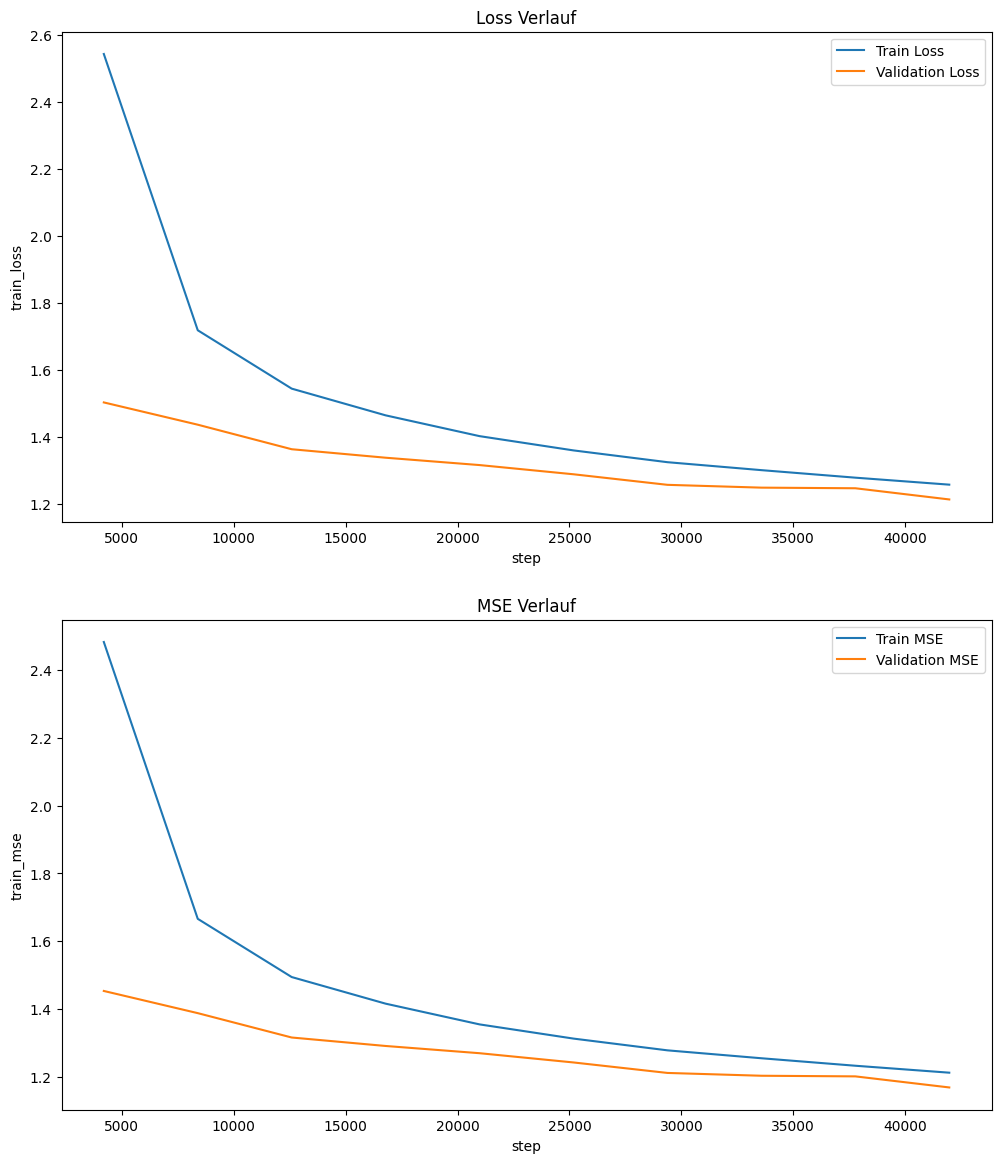

In [5]:
def run_pipeline(max_epochs=30,batch_size=32,hidden_size=128,num_layers=4,dropout=0.2,lr = 0.0003 ,logger_name="gru_training"):
    # Logger
    logger = CSVLogger("lightning_logs", name=logger_name)

    # MongoDB-Client
    mongo_client = MongoDb()

    # DataModule
    data_module = DataModule(mongo_client, batch_size=batch_size)

    # Modell
    model = GRUModel(
        seq_input_size=15,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        lr=lr
    )

    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=7,
        verbose=True,
        mode="min",
        min_delta=0.001
    )

    # Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator="auto",
        devices=1,
        log_every_n_steps=50,
        callbacks=[early_stop_callback]
    )

    # Training
    trainer.fit(model, datamodule=data_module)

    print_training_summary(logger)

    plot_training_metrics(logger)

    # Modell speichern
    model_path = os.path.join("saved_models", f"gru_model_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.pt")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Modell gespeichert unter: {model_path}")

def random_search(n_trials=20, max_epochs=10):
    best_val_loss = float("inf")
    best_params = None
    best_r2 = -float("inf")

    # Erweiterte Wertebereiche für bessere Suche
    hidden_size_choices = [32, 64, 128, 256, 512]
    num_layers_choices = [1, 2, 3, 4, 5, 6]
    dropout_choices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    lr_choices = [1e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 2e-3]
    batch_size_choices = [8, 16, 32, 64, 128]
    bidirectional_choices = [True, False]
    l1_weight_choices = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]

    results = []

    for trial in range(n_trials):
        print(f"\n=== Trial {trial+1}/{n_trials} ===")

        # Zufällige Parameter
        hidden_size = random.choice(hidden_size_choices)
        num_layers = random.choice(num_layers_choices)
        dropout = random.choice(dropout_choices)
        lr = random.choice(lr_choices)
        batch_size = random.choice(batch_size_choices)
        bidirectional = random.choice(bidirectional_choices)
        l1_weight = random.choice(l1_weight_choices)

        print(f"Testing: hidden_size={hidden_size}, layers={num_layers}, dropout={dropout}")
        print(f"         lr={lr}, batch_size={batch_size}, bidirectional={bidirectional}, l1_weight={l1_weight}")

        try:
            # Setup
            logger = CSVLogger("lightning_logs", name=f"gru_trial_{trial+1}")
            mongo_client = MongoDb()
            data_module = DataModule(mongo_client, batch_size=batch_size)

            # Dynamisches Modell mit aktuellen Parametern
            model = GRUModel(
                seq_input_size=15,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout,
                lr=lr
            )

            # Temporär bidirectional Parameter setzen
            model.gru.bidirectional = bidirectional
            if not bidirectional:
                model.attention = AttentionLayer(hidden_size)
                model.fc[0] = nn.Linear(hidden_size, 128)

            early_stop = EarlyStopping(monitor="val_loss", patience=8, mode="min")

            trainer = Trainer(
                max_epochs=max_epochs,
                logger=logger,
                accelerator="auto",
                devices=1,
                callbacks=[early_stop],
                enable_progress_bar=False,
            )

            trainer.fit(model, datamodule=data_module)

            # Metriken sammeln
            val_loss = trainer.callback_metrics.get("val_loss", float("inf"))
            val_r2 = trainer.callback_metrics.get("val_r2", -float("inf"))

            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.item()
            if isinstance(val_r2, torch.Tensor):
                val_r2 = val_r2.item()

            print(f"Results: val_loss={val_loss:.4f}, val_r2={val_r2:.4f}")

            # Beste Parameter basierend auf R² (besser als Loss für Regression)
            if val_r2 > best_r2:
                best_r2 = val_r2
                best_val_loss = val_loss
                best_params = {
                    "hidden_size": hidden_size,
                    "num_layers": num_layers,
                    "dropout": dropout,
                    "lr": lr,
                    "batch_size": batch_size,
                    "bidirectional": bidirectional,
                    "l1_weight": l1_weight
                }

            results.append({
                "trial": trial+1,
                "val_loss": val_loss,
                "val_r2": val_r2,
                "params": {
                    "hidden_size": hidden_size,
                    "num_layers": num_layers,
                    "dropout": dropout,
                    "lr": lr,
                    "batch_size": batch_size,
                    "bidirectional": bidirectional,
                    "l1_weight": l1_weight
                }
            })

        except Exception as e:
            print(f"Trial {trial+1} failed: {e}")
            continue

    # Ergebnisse sortieren und anzeigen
    results.sort(key=lambda x: x["val_r2"], reverse=True)

    print(f"\n=== TOP 5 RESULTS ===")
    for i, result in enumerate(results[:5]):
        print(f"{i+1}. R²: {result['val_r2']:.4f}, Loss: {result['val_loss']:.4f}")
        print(f"   Params: {result['params']}")

    print(f"\n=== BEST PARAMETERS ===")
    print(f"Best R²: {best_r2:.4f}")
    print(f"Best Loss: {best_val_loss:.4f}")
    print(f"Parameters: {best_params}")

    return best_params

# Aufruf:
best_params = random_search(n_trials=5, max_epochs=5)

# Training mit besten Parametern
run_pipeline(
    max_epochs=30,
    batch_size=best_params["batch_size"],
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    lr=best_params["lr"],
    logger_name="gru_best_run"
)


In [5]:
def get_final_scores(csv_path):
    import pandas as pd
    
    # CSV laden
    df = pd.read_csv(csv_path)
    
    # Metriken pro Epoch zusammenfassen
    epoch_summary = []
    for epoch in df['epoch'].unique():
        epoch_data = df[df['epoch'] == epoch]
        
        # Trainings-Metriken
        train_data = epoch_data[epoch_data['train_loss'].notna()]
        # Validierungs-Metriken  
        val_data = epoch_data[epoch_data['val_loss'].notna()]
        
        if not train_data.empty and not val_data.empty:
            summary = {
                'epoch': epoch,
                'train_loss': train_data['train_loss'].iloc[0],
                'val_loss': val_data['val_loss'].iloc[0],
                'train_mae': train_data['train_mae'].iloc[0],
                'val_mae': val_data['val_mae'].iloc[0],
                'train_mse': train_data['train_mse'].iloc[0],
                'val_mse': val_data['val_mse'].iloc[0],
                'train_r2': train_data['train_r2'].iloc[0],
                'val_r2': val_data['val_r2'].iloc[0]
            }
            epoch_summary.append(summary)
    
    summary_df = pd.DataFrame(epoch_summary)
    
    # Letzte Werte
    final = summary_df.iloc[-1]
    print(f"Finale Scores (Epoch {final['epoch']:.0f}):")
    print(f"Train Loss: {final['train_loss']:.4f}")
    print(f"Val Loss:   {final['val_loss']:.4f}")
    print(f"Train MAE:  {final['train_mae']:.4f}")
    print(f"Val MAE:    {final['val_mae']:.4f}")
    print(f"Train MSE:  {final['train_mse']:.4f}")
    print(f"Val MSE:    {final['val_mse']:.4f}")
    print(f"Train R²:   {final['train_r2']:.4f}")
    print(f"Val R²:     {final['val_r2']:.4f}")
    
    # Beste Werte
    best_val_loss = summary_df.loc[summary_df['val_loss'].idxmin()]
    best_val_r2 = summary_df.loc[summary_df['val_r2'].idxmax()]
    
    print(f"\nBeste Val Loss: {best_val_loss['val_loss']:.4f} (Epoch {best_val_loss['epoch']:.0f})")
    print(f"Beste Val R²:   {best_val_r2['val_r2']:.4f} (Epoch {best_val_r2['epoch']:.0f})")
    
    return summary_df

get_final_scores("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_best_run/version_1/metrics.csv")

Finale Scores (Epoch 29):
Train Loss: 1.1533
Val Loss:   1.1736
Train MAE:  0.8386
Val MAE:    0.8465
Train MSE:  1.0694
Val MSE:    1.0889
Train R²:   0.2756
Val R²:     0.1372

Beste Val Loss: 1.1682 (Epoch 25)
Beste Val R²:   0.1407 (Epoch 25)


,epoch,train_loss,val_loss,train_mae,val_mae,train_mse,val_mse,train_r2,val_r2
0,0,1.957090,1.384224,1.087204,0.925902,1.848367,1.291635,-0.257635,-0.023913
1,1,1.488073,1.426925,0.956983,0.944205,1.392375,1.332504,0.054629,-0.054560
2,2,1.377720,1.280860,0.918630,0.887196,1.285857,1.192140,0.128091,0.060147
3,3,1.328211,1.246489,0.900104,0.874393,1.238199,1.159050,0.161071,0.081434
4,4,1.293545,1.236738,0.889355,0.869480,1.204611,1.149791,0.182994,0.093075
5,5,1.273528,1.227604,0.882172,0.867752,1.185313,1.140830,0.196038,0.098142
6,6,1.256077,1.218091,0.875924,0.863547,1.168485,1.131736,0.209006,0.105676
7,7,1.243666,1.224863,0.871721,0.866539,1.156497,1.138209,0.214857,0.099238
8,8,1.234413,1.217549,0.868540,0.864219,1.147557,1.131129,0.222298,0.106504
9,9,1.225152,1.225828,0.864980,0.867954,1.138657,1.139034,0.227816,0.094770


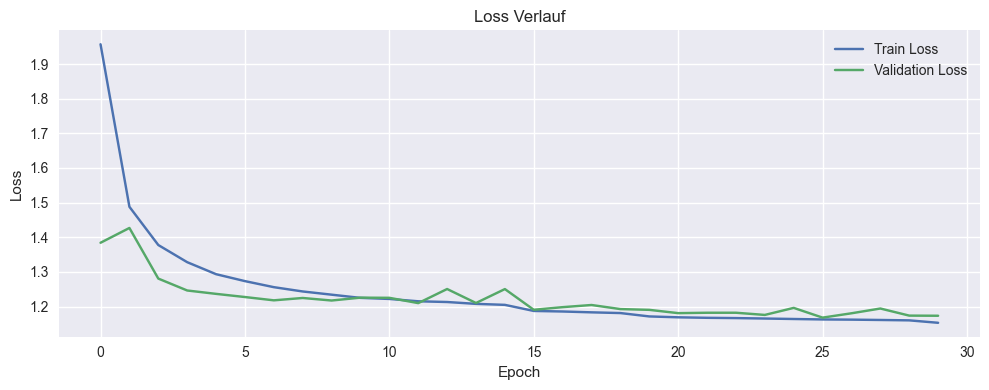

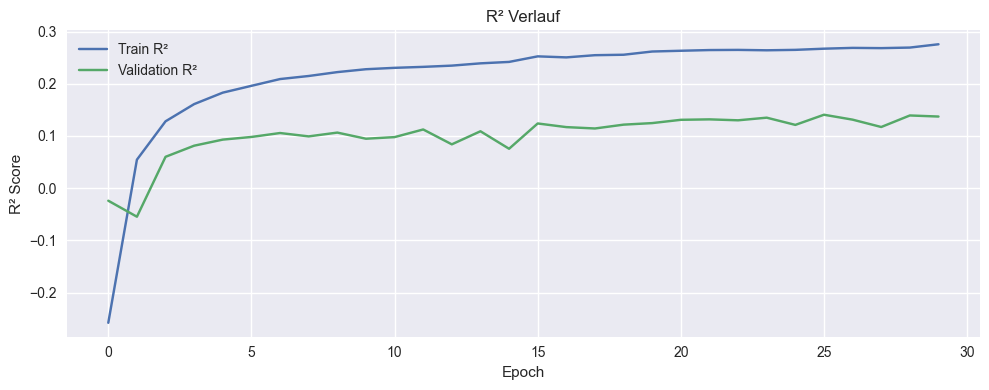

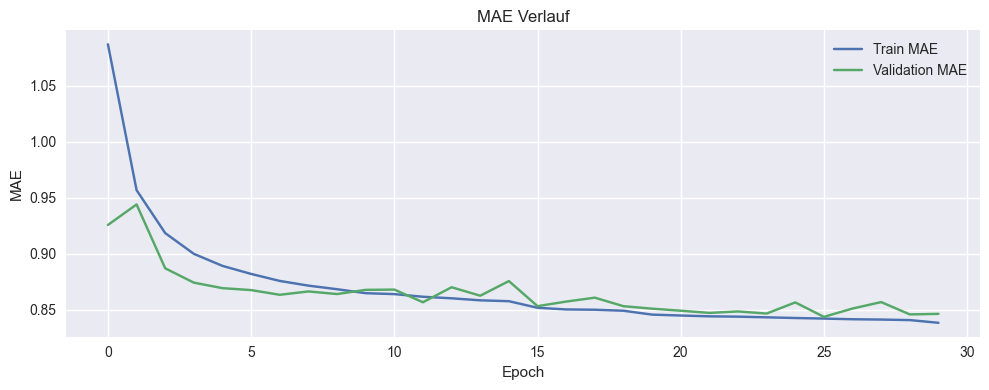

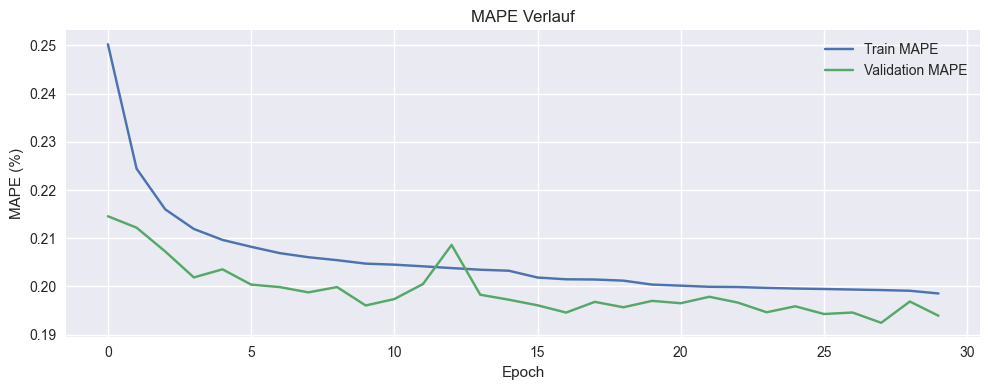

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei laden
df = pd.read_csv("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_best_run/version_1/metrics.csv")  # Pfad ggf. anpassen
df_clean = df.groupby("epoch").agg("first").reset_index()
plt.style.use("seaborn-v0_8")

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_loss"], label="Train Loss")
plt.plot(df_clean["epoch"], df_clean["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_r2"], label="Train R²")
plt.plot(df_clean["epoch"], df_clean["val_r2"], label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_mae"], label="Train MAE")
plt.plot(df_clean["epoch"], df_clean["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_mape"], label="Train MAPE")
plt.plot(df_clean["epoch"], df_clean["val_mape"], label="Validation MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE (%)")
plt.title("MAPE Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

INFO:tensorboard:No path found after logs/lightning_logs/version_24/events.out.tfevents.1754401215.Mac.fritz.box.29116.0


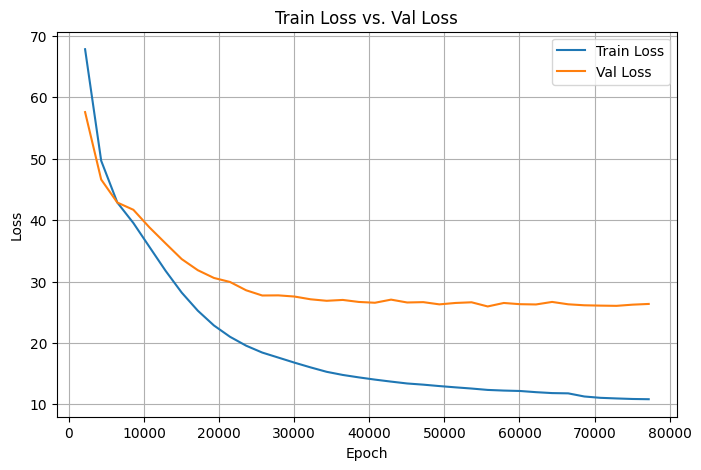

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# EventAccumulator initialisieren und laden
ea = event_accumulator.EventAccumulator(trainer.logger.log_dir)
ea.Reload()

# Die richtigen Keys für die Losses
val_loss = ea.Scalars('val_loss')
train_loss = ea.Scalars('train_loss_epoch')

# Plot
plt.figure(figsize=(8,5))
plt.plot([x.step for x in train_loss], [x.value for x in train_loss], label='Train Loss')
plt.plot([x.step for x in val_loss], [x.value for x in val_loss], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Val Loss')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import sys
import json
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.models.gru.predict import predict

linkedin_data_str = r'''{"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}'''

try:
    # JSON-String in Dictionary umwandeln
    profile_data = json.loads(linkedin_data_str)
    
    # Vorhersage machen
    result = predict(profile_data)
    print("\nVorhersageergebnis:")
    print(f"Tage bis zum Wechsel: {result['confidence']}")
    print(f"Status: {result['status']}")
    print("\nEmpfehlungen:")
    for rec in result['recommendations']:
        print(f"- {rec}")
    
    # SHAP-Erklärungen anzeigen
    print("\n" + "="*60)
    print("SHAP FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'shap_explanations' in result and result['shap_explanations']:
        for exp in result['shap_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine SHAP-Erklärungen verfügbar")
    
    # LIME-Erklärungen anzeigen
    print("\n" + "="*60)
    print("LIME FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'lime_explanations' in result and result['lime_explanations']:
        for exp in result['lime_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine LIME-Erklärungen verfügbar")
        
except json.JSONDecodeError as e:
    print(f"JSON Fehler: {str(e)}")
    print(f"Fehler an Position: {e.pos}")
    print(f"Zeile: {e.lineno}, Spalte: {e.colno}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/predict.py:344: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis


Load latest model: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/saved_models/gru_model_20250807_184702.pt

Model weights:
gru.weight_ih_l0: 0.0008 (mean)
gru.weight_hh_l0: -0.0000 (mean)
gru.bias_ih_l0: -0.0040 (mean)
gru.bias_hh_l0: -0.0046 (mean)
gru.weight_ih_l0_reverse: -0.0006 (mean)
gru.weight_hh_l0_reverse: 0.0000 (mean)
gru.bias_ih_l0_reverse: -0.0041 (mean)
gru.bias_hh_l0_reverse: -0.0040 (mean)
gru.weight_ih_l1: 0.0000 (mean)
gru.weight_hh_l1: -0.0000 (mean)
gru.bias_ih_l1: 0.0556 (mean)
gru.bias_hh_l1: 0.0555 (mean)
gru.weight_ih_l1_reverse: 0.0000 (mean)
gru.weight_hh_l1_reverse: -0.0000 (mean)
gru.bias_ih_l1_reverse: 0.0586 (mean)
gru.bias_hh_l1_reverse: 0.0586 (mean)
attention.attention.0.weight: -0.0000 (mean)
attention.attention.0.bias: 0.0000 (mean)
attention.attention.2.weight: 0.0000 (mean)
attention.attention.2.bias: 0.0000 (mean)
fc.0.weight: -0.0002 (mean)
fc.0.bias: -0.0862 (mean)
fc.3.weight: -0.0233 (mean)
fc.3.

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

SHAP Feature-Einflüsse:
second latest previous position level: 17.6% (SHAP)
position id: 16.6% (SHAP)
job changes total: 14.5% (SHAP)
job average duration: 13.1% (SHAP)
latest previous position duration: 11.8% (SHAP)
position level: 9.9% (SHAP)
job positions total: 9.4% (SHAP)
latest previous position industry: 5.1% (SHAP)
position average duration: 1.2% (SHAP)
industry: 0.9% (SHAP)

Calculate LIME explanations...


LIME Feature-Einflüsse:
job experience total: 70.3% (LIME)
position level: 7.0% (LIME)
industry: 6.5% (LIME)
latest previous position duration: 5.1% (LIME)
job average duration: 4.4% (LIME)
job positions total: 2.8% (LIME)
job changes total: 1.5% (LIME)
position average duration: 1.4% (LIME)
age category: 0.8% (LIME)
position id: 0.3% (LIME)

=== Prediction completed ===

Vorhersageergebnis:
Tage bis zum Wechsel: 887.4855346679688
Status: short-term change

Empfehlungen:
- High probability of job change within the next month

SHAP FEATURE-ERKLÄRUNGEN:
- second latest previous position level: 17.6% - This feature influences the prediction.
- position id: 16.6% - This feature influences the prediction.
- job changes total: 14.5% - This feature influences the prediction.
- job average duration: 13.1% - This feature influences the prediction.
- latest previous position duration: 11.8% - This feature influences the prediction.
- position level: 9.9% - This feature influences the prediction.